In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 기본블록


In [3]:
def build_resnet_block(input_layer ,num_cnn=2,stage_num=2, channel=64, is_50=False):
    
    x = input_layer
    short = x
  
    if not is_50:
        for cnn_num in range(num_cnn):
            if cnn_num == 0:
                if stage_num == 2:
                    stride = 1
                else:
                    stride = 2
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(3, 3), 
                                        padding='same',
                                        strides=stride,
                                        name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                        )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                        )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn2')(x)
                
                
                short = keras.layers.Conv2D(filters=channel,
                                            kernel_size=(1, 1),
                                            strides=stride,
                                            padding='same',
                                            name=f'stage{stage_num}_{cnn_num+1}_short',
                                            )(short)
                short = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn3')(short)
                x = keras.layers.Add()([x, short])
                
                x = keras.layers.Activation('relu')(x)

                short = x
            else:
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                        )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                        )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn2')(x)

                x = keras.layers.Add()([x, short])

                x = keras.layers.Activation('relu')(x)

                short = x

    else:
        for cnn_num in range(num_cnn):
            if cnn_num == 0:
                
                if stage_num == 2:
                    stride = 1
                else:
                    stride = 2
                    
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(1, 1),
                                        strides = stride,
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stae{stage_num}_{cnn_num+1}_bn2')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel*4,
                                        kernel_size=(1, 1),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv3',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn3')(x)
                
             
                short = keras.layers.Conv2D(filters=channel*4,
                                            kernel_size=(1, 1),
                                            strides=stride,
                                            padding='same',
                                            name=f'stage{stage_num}_{cnn_num+1}_short',
                                            )(short)
                short = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn4')(short)
                x = keras.layers.Add()([x, short])
                x = keras.layers.Activation('relu')(x)
                
                short = x
            else:
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(1, 1),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stae{stage_num}_{cnn_num+1}_bn2')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel*4,
                                        kernel_size=(1, 1),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv3',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn3')(x)
                
                
                x = keras.layers.Add()([x, short])
                    
                x = keras.layers.Activation('relu')(x)
                
                short = x

                    
    return x
    

In [4]:
def build_resnet(input_shape=(32, 32, 3), is_50=False):
    
    num_cnn_ls = [3, 4, 6, 3]
    channel_ls = [64, 128, 256, 512]
    num_classes = 2
    
    
        
    input_layer = keras.layers.Input(shape=input_shape)

    x = input_layer
    x = keras.layers.Conv2D(filters = 64,
                            kernel_size=(7, 7),
                            strides=2,
                            kernel_initializer='he_normal',
                            padding='same',
                            name=f'conv2d_0',
                            )(x)

    x = keras.layers.BatchNormalization(name=f'batch_normalization_0')(x)
    x = keras.layers.Activation('relu', name=f'activation_0')(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same', name=f'stage2_0_maxpooling')(x)
    
    output = x 
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_ls, channel_ls)):
        output = build_resnet_block(output,
                                    num_cnn=num_cnn,
                                    stage_num = i+2,
                                    channel=channel,
                                    is_50 = is_50,
                                    )

    output = keras.layers.AveragePooling2D(pool_size = 1,
                                           padding='same',
                                           name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten_6')(output)
    output = keras.layers.Dense(num_classes, activation='softmax',name='predictions')(output)

    model = keras.Model(inputs=input_layer, outputs=output)

    return model

### ResNet-34, ResNet-50 Complete Model


In [5]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_0 (Conv2D)               (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_0 (BatchNor (None, 16, 16, 64)   256         conv2d_0[0][0]                   
__________________________________________________________________________________________________
activation_0 (Activation)       (None, 16, 16, 64)   0           batch_normalization_0[0][0]      
_______________________________________________________________________________________

In [6]:
resnet_50 = build_resnet(is_50=True)
resnet_50.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_0 (Conv2D)               (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_0 (BatchNor (None, 16, 16, 64)   256         conv2d_0[0][0]                   
__________________________________________________________________________________________________
activation_0 (Activation)       (None, 16, 16, 64)   0           batch_normalization_0[0][0]      
_______________________________________________________________________________________

### plainnet

In [7]:
def build_plainnet_block(input_layer ,num_cnn=2,stage_num=2, channel=64, is_50=False):
    
    x = input_layer
    short = x
  
    if not is_50:
        for cnn_num in range(num_cnn):
            if cnn_num == 0:
                if stage_num == 2:
                    stride = 1
                else:
                    stride = 2
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(3, 3), 
                                        padding='same',
                                        strides=stride,
                                        name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                        )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                        )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn2')(x)
                
                
                x = keras.layers.Activation('relu')(x)

                short = x
            else:
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                        )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                        )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn2')(x)


                x = keras.layers.Activation('relu')(x)

                short = x

    else:
        for cnn_num in range(num_cnn):
            if cnn_num == 0:
                
                if stage_num == 2:
                    stride = 1
                else:
                    stride = 2
                    
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(1, 1),
                                        strides = stride,
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stae{stage_num}_{cnn_num+1}_bn2')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel*4,
                                        kernel_size=(1, 1),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv3',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn3')(x)
                
                x = keras.layers.Activation('relu')(x)
                
                short = x
            else:
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(1, 1),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stae{stage_num}_{cnn_num+1}_bn2')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel*4,
                                        kernel_size=(1, 1),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv3',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn3')(x)
                
                    
                x = keras.layers.Activation('relu')(x)
                
                short = x

                    
    return x
    

In [8]:
def build_plainnet(input_shape=(224, 224, 3), is_50=False):
    
    num_cnn_ls = [3, 4, 6, 3]
    channel_ls = [64, 128, 256, 512]
    num_classes = 2
    
    
        
    input_layer = keras.layers.Input(shape=input_shape)

    x = input_layer
    x = keras.layers.Conv2D(filters = 64,
                            kernel_size=(7, 7),
                            strides=2,
                            kernel_initializer='he_normal',
                            padding='same',
                            name=f'conv2d_0',
                            )(x)

    x = keras.layers.BatchNormalization(name=f'batch_normalization_0')(x)
    x = keras.layers.Activation('relu', name=f'activation_0')(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same', name=f'stage2_0_maxpooling')(x)
    
    output = x 
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_ls, channel_ls)):
        output = build_plainnet_block(output,
                                    num_cnn=num_cnn,
                                    stage_num = i+2,
                                    channel=channel,
                                    is_50 = is_50,
                                    )

    output = keras.layers.AveragePooling2D(pool_size = 1,
                                           padding='same',
                                           name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten_6')(output)
    output = keras.layers.Dense(num_classes, activation='softmax',name='predictions')(output)

    model = keras.Model(inputs=input_layer, outputs=output)

    return model

### ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34


### 데이터  "cats_vs_dogs"

In [9]:
import urllib3
urllib3.disable_warnings()
splits = ['train[:80%]', 'train[80%:]']

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=list(splits),
    shuffle_files=True,
    with_info=True,
)

In [10]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [11]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [12]:
def normalize_and_resize_img(image, label):
    
    # 이미지의 크기가 달라 일정하게 resize
    image = tf.image.resize(image, (224, 224))
    
    return tf.cast(image, tf.float32)/255., label

In [13]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=1)
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds=ds.repeat()
        ds=ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds 

In [14]:
ds_info.features["label"].num_classes

2

In [15]:
ds_info.features["label"].names

['cat', 'dog']

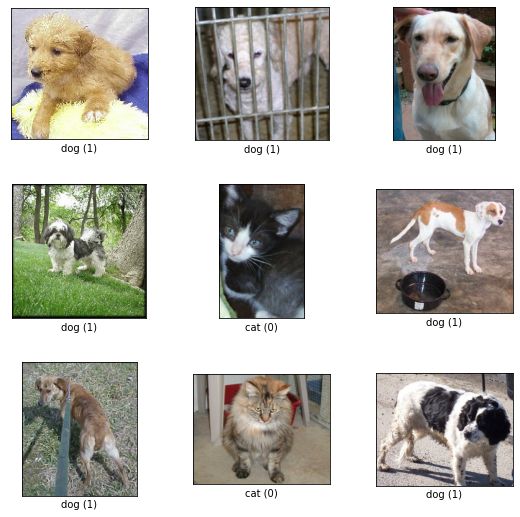

In [16]:
fig = tfds.show_examples(ds_train, ds_info)

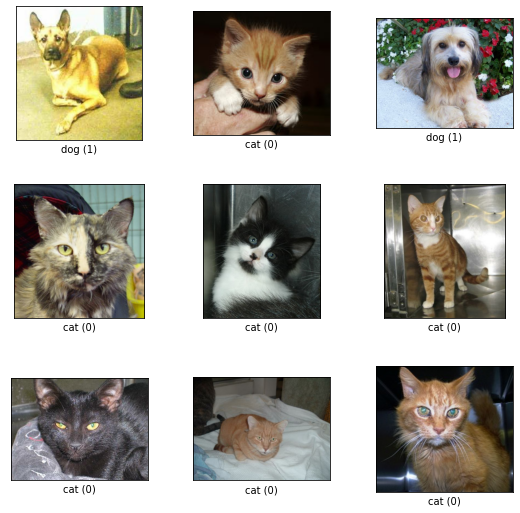

In [17]:
fig = tfds.show_examples(ds_test, ds_info)

In [18]:
resnet_34 = build_resnet(input_shape=(224, 224, 3))
resnet_50 = build_resnet(is_50=True)

resnet_34_plain = build_plainnet(input_shape=(224, 224, 3))
resnet_50_plain = build_plainnet(is_50=True)


In [19]:
BATCH_SIZE =16
EPOCH = 10

In [20]:
ds_train, ds_info = tfds.load(
'cats_vs_dogs',
split='train[:80%]',
as_supervised=True,
    with_info=True,
)

ds_test, ds_info = tfds.load(
'cats_vs_dogs',
split='train[80%:]',
as_supervised=True,
    with_info=True,
)


ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test= apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [21]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
   2/1163 [..............................] - ETA: 53s - loss: 6.7514 - accuracy: 0.5000WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0349s vs `on_train_batch_end` time: 0.0561s). Check your callbacks.


1163/1163 [==============================] - 97s 83ms/step - loss: 2.0941 - accuracy: 0.5326 - val_loss: 0.6919 - val_accuracy: 0.5742
Epoch 2/10
1163/1163 [==============================] - 101s 87ms/step - loss: 0.6725 - accuracy: 0.5817 - val_loss: 0.6788 - val_accuracy: 0.6020
Epoch 3/10
1163/1163 [==============================] - 93s 80ms/step - loss: 0.6575 - accuracy: 0.6114 - val_loss: 0.6658 - val_accuracy: 0.6078
Epoch 4/10
1163/1163 [==============================] - 91s 78ms/step - loss: 0.6426 - accuracy: 0.6299 - val_loss: 0.6453 - val_accuracy: 0.6273
Epoch 5/10
1163/1163 [==============================] - 91s 78ms/step - loss: 0.6176 - accuracy: 0.6589 - val_loss: 0.7098 - val_accuracy: 0.6070
Epoch 6/10
1163/1163 [==============================] - 90s 78ms/step - loss: 0.5833 - accuracy: 0.6872 - val_loss: 0.5972 - val_accuracy: 0.6913
Epoch 7/10
1163/1163 [==============================] - 92s 79ms/step - loss: 0.5570 - accuracy: 0.7082 - val_loss: 0.5795 - val_accur

In [22]:
resnet_34_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
    metrics=['accuracy'],
)

history_34_plain = resnet_34_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
   2/1163 [..............................] - ETA: 1:11 - loss: 1.0303 - accuracy: 0.5312WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0283s vs `on_train_batch_end` time: 0.0474s). Check your callbacks.


1163/1163 [==============================] - 87s 75ms/step - loss: 1.1039 - accuracy: 0.5095 - val_loss: 0.6927 - val_accuracy: 0.5194
Epoch 2/10
1163/1163 [==============================] - 87s 75ms/step - loss: 0.6911 - accuracy: 0.5131 - val_loss: 0.6962 - val_accuracy: 0.4996
Epoch 3/10
1163/1163 [==============================] - 87s 75ms/step - loss: 0.6912 - accuracy: 0.5141 - val_loss: 0.6980 - val_accuracy: 0.4812
Epoch 4/10
1163/1163 [==============================] - 87s 75ms/step - loss: 0.6906 - accuracy: 0.5135 - val_loss: 0.7008 - val_accuracy: 0.4860
Epoch 5/10
1163/1163 [==============================] - 87s 75ms/step - loss: 0.6900 - accuracy: 0.5177 - val_loss: 0.6936 - val_accuracy: 0.5278
Epoch 6/10
1163/1163 [==============================] - 88s 76ms/step - loss: 0.6901 - accuracy: 0.5067 - val_loss: 0.7024 - val_accuracy: 0.4953
Epoch 7/10
1163/1163 [==============================] - 87s 75ms/step - loss: 0.6899 - accuracy: 0.5114 - val_loss: 0.6980 - val_accura

In [23]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


ValueError: in user code:

    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:386 call
        inputs, training=training, mask=mask)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer predictions is incompatible with the layer: expected axis -1 of input shape to have value 2048 but received input with shape [None, 100352]


In [ ]:
resnet_50_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9),
    metrics=['accuracy'],
)

history_50_plain = resnet_50_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(history_34_plain.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_34_plain'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_50.history['loss'], 'r')
plt.plot(history_50_plain.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'resnet_50_plain'], loc='upper left')
plt.show()